该脚本学习多种降维算法的实现与应用。  
目标：  
①使用降维之后的数据集进行分类并比较训练时间和模型效果  
②使用降维来可视化MNIST数据集的cluster分布


### Setup

In [33]:
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
Figure_save_dir = 'Plots_and_Images/'
def save_fig(figname):
    print('Saving figure .....')
    path = Figure_save_dir+name+'.png'
    plt.savefig(path, format='png',dpi=300)

#### 一、基础部分

产生3D数据集

In [5]:
#复制过来的数据集
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

实现vanilla PCA:  
对数据集X进行SVD分解，得到的V.T矩阵中的每一列为一个主成分。用X和W_d做dot product即可求出降维至d维的新数据集

$
\mathbf{V}^T =
\begin{pmatrix}
  \mid & \mid & & \mid \\
  \mathbf{c_1} & \mathbf{c_2} & \cdots & \mathbf{c_n} \\
  \mid & \mid & & \mid
\end{pmatrix}
$

In [16]:
#注意一定要先进行center
X_centered = X - np.mean(X,axis=0)
U,S,V = np.linalg.svd(X_centered)
W2 = V.T[:,:2]
X_2d = X_centered.dot(W2)

In [17]:
print(X.shape,X_2d.shape)

(60, 3) (60, 2)


使用sklearn实现PCA:

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_2d_sklearn = pca.fit_transform(X)

In [20]:
np.allclose(X_2d,X_2d_sklearn)  

False

注意：主成分的方向不稳定：每一次进行pca，某些主成分的方向可能变成相反方向。但是主成分所代表的axes通常不会改变

In [23]:
X_2d[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [22]:
X_2d_sklearn[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

### 二、使用PCA对数据进行可视化

1.简单版

In [15]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

digits = load_digits()
X = digits.data
y = digits.target
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
# 聚类问题经常需要直观的展现数据，降维度的一个直接目的也为此；因此我们这里多展现几个图片直观一些。

In [16]:
X_pca.shape

(1797, 2)

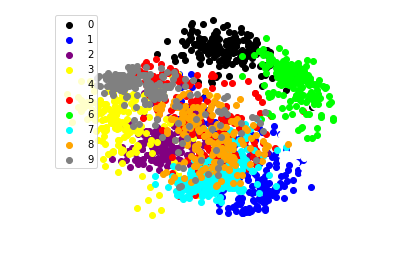

In [20]:
import matplotlib.pyplot as plt
def plot_pca_scatter(X,y):
    colors = ['black', 'blue', 'purple', 'yellow', 'white', 'red', 'lime', 'cyan', 'orange', 'gray']
    for i in range(len(colors)):
        plt.scatter(X[y==i,0],X[y==i,1],c=colors[i])
        plt.legend(digits.target_names)
        plt.xlabel('First_PC')
        plt.ylabel('Second_PC')
        plt.axis('off')
plot_pca_scatter(X_pca,y)

改进：每个类别使用较少的点数表示

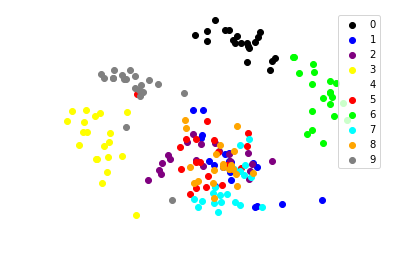

In [28]:
def plot_pca_scatter(X,y,intensity):
    colors = ['black', 'blue', 'purple', 'yellow', 'white', 'red', 'lime', 'cyan', 'orange', 'gray']
    for i in range(len(colors)):
        plt.scatter(X[y==i,0][:intensity],X[y==i,1][:intensity],c=colors[i])
        plt.legend(digits.target_names)
        plt.xlabel('First_PC')
        plt.ylabel('Second_PC')
        plt.axis('off')
plot_pca_scatter(X_pca,y,20)

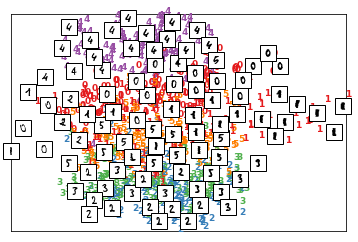

In [70]:
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  #初始化一个较大的距离
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1) #计算当前样例与已有的所有样例的距离，若与最近的样例距离小于阈值，则不绘出
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]  #将新样例添加入已绘制样例的列表
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
plot_embedding(X_pca)